In [1]:
import rebound as rb
import celmech as cm
import scipy
import numpy as np
import matplotlib.pyplot as plt
import radvel
import pandas as pd
import reboundx

# make font bigger
plt.rc('font', size=16)

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep =';')
hd_data.BJD -= 2.4e6

In [3]:
#Least squares fit: 
fit_params = [ 2.28513053e+02, 7.27743508e+00, 5.39371890e+04, -1.78110513e-01, 
              -4.66450116e-02, 3.43378023e+02, 1.78603199e+01, 5.40186750e+04,
               1.32165040e-01, 9.73129308e-02, -5.29039776e-01] 

# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor for au/day to m/s

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, inclination, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is jit
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')

    sim.add(m = star_mass)  # star mass as a constant
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 3], params[5*i + 4])  # omega from arctan of sesin, secos
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim

In [4]:
# make simulation
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
inner = sim.particles[1]
outer = sim.particles[2]

cm.nbody_simulation_utilities.align_simulation(sim)
# convert to poincarehamiltonian
pvars = cm.Poincare.from_Simulation(sim)
pham = cm.PoincareHamiltonian(pvars)
pham.add_MMR_terms(3, 1, max_order=1, inclinations=False)
pham.H

                                                               ⎛η₁⋅sin(2⋅λ₁ - 
  C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅⎜──────────────
                                                               ⎜   ___________
                                                               ⎝ ╲╱ \Lambda_{1
- ────────────────────────────────────────────────────────────────────────────
                                                  a_{2,0}                     
                                                                              

3⋅λ₂)   κ₁⋅cos(2⋅λ₁ - 3⋅λ₂)⎞                                                  
───── + ───────────────────⎟   C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\
____       _______________ ⎟                                                  
,0}      ╲╱ \Lambda_{1,0}  ⎠                                                  
──────────────────────────── - ───────────────────────────────────────────────
                                                   

In [5]:
import sympy as sp
# defining stuff:

# action variables
# Lambda1, Lambda2, Gamma1, Gamma2, Q1, Q2 = sp.symbols('Lambda_1, Lambda_2, Gamma_1, Gamma_2, Q_1, Q_2')
# old angle coordinates
lambda1, lambda2, pomega1, pomega2, Omega1, Omega2 = sp.symbols('lambda_1, lambda_2, varpi_1, varpi_2, Omega_1, Omega_2')
# new angle coordinates
theta1, theta2, l, psi, phi1, phi2 = sp.symbols('theta_1, theta_2, l, psi, phi_1, phi_2')
p1, p2, L, Psi, Phi1, Phi2 = sp.symbols('p_1, p_2, L, Psi, Phi_1, Phi_2')

# converts
# lambda_1, lambda_2, pomega_1, pomega_2, Omega_1, Omega_2 to
# theta_1, theta_2, l, psi, phi_1, phi_2
pmatrix = [[-2, 3, 1, 0, 0, 0], [-2, 3, 0, 1, 0, 0], [-2, 3, 0, 0, 0, 0], 
           [1, -1, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]

ct = cm.CanonicalTransformation.from_poincare_angles_matrix(pvars, pmatrix, 
                                                            new_qp_pairs = [(theta1, p1), (theta2, p2), 
                                                                            (l, L), (psi, Psi), 
                                                                            (phi1, Phi1), (phi2, Phi2)])
ct.old_qp_vars, ct.new_qp_vars

([λ₁, η₁, ρ₁, λ₂, η₂, ρ₂, Λ₁, κ₁, σ₁, Λ₂, κ₂, σ₂], [θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, 
p₂, L, Ψ, Φ₁, Φ₂])

In [6]:
new_ham = ct.old_to_new_hamiltonian(pham)
ctxy = cm.CanonicalTransformation.polar_to_cartesian(new_ham.full_qp_vars,[0,1])
hamxy = ctxy.old_to_new_hamiltonian(new_ham)

In [7]:
y1, y2, _, _, _, _, x1, x2, L, Psi, _, _ = hamxy.qp_vars

In [8]:
new_ham.qp_vars, hamxy.qp_vars

([θ₁, θ₂, l, ψ, φ₁, φ₂, p₁, p₂, L, Ψ, Φ₁, Φ₂], [y₁, y₂, l, ψ, φ₁, φ₂, x₁, x₂, 
L, Ψ, Φ₁, Φ₂])

In [9]:
z = [y1, y2, x1, x2, L, Psi]

cons_flow = sp.Matrix([hamxy.N_Lie_deriv(v) for v in z])
cons_flow

⎡                                                                             
⎢                                                                       2.4252
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛    2                   2          2          2          2      2         
⎢  ⎝36⋅L  - 24⋅L⋅Ψ + 36⋅L⋅x₁  + 36⋅L⋅x₂  + 36⋅L⋅y₁  + 36⋅L⋅y₂  + 4⋅Ψ  - 12⋅Ψ⋅x
⎢                                                                             
⎢                                                                             
⎢                                                                       2.4252
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢  ⎛    2                   2          2          2          2      2         
⎢  ⎝36⋅L  - 24⋅L⋅Ψ + 36⋅L⋅x₁  + 36⋅L⋅x₂  + 36⋅L⋅y₁  

In [10]:
# symbols

tau_a_1, tau_e_1 = sp.symbols('tau_a_1, tau_e_1')
tau_a_2, tau_e_2 = sp.symbols('tau_a_2, tau_e_2')
Lambda1 = pham.qp_vars[6]
Lambda2 = pham.qp_vars[9]
eta_1 = pham.qp_vars[1]
eta_2 = pham.qp_vars[4]
kappa_1 = pham.qp_vars[7]
kappa_2 = pham.qp_vars[10]
t = sp.symbols('t')

# dLambda, deta, dkappa equations:

dLambda_1 = -Lambda1/(2 * tau_a_1)
dLambda_2 = -Lambda2/(2 * tau_a_2)

deta_1 = -eta_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
deta_2 = -eta_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dkappa_1 = -kappa_1 * (1/(4 * tau_a_1) + 1/tau_e_1)
dkappa_2 = -kappa_2 * (1/(4 * tau_a_2) + 1/tau_e_2)

dLambda_1, deta_1, dkappa_1

⎛ -Λ₁        ⎛ 1       1   ⎞      ⎛ 1       1   ⎞⎞
⎜──────, -η₁⋅⎜──── + ──────⎟, -κ₁⋅⎜──── + ──────⎟⎟
⎝2⋅τₐ ₁      ⎝τₑ ₁   4⋅τₐ ₁⎠      ⎝τₑ ₁   4⋅τₐ ₁⎠⎠

In [11]:
dissipative = sp.zeros(len(pham.values), 1)

# add lambda, eta, kappa dissipative terms
dissipative[6] = dLambda_1
dissipative[9] = dLambda_2

dissipative[1] = deta_1
dissipative[4] = deta_2

dissipative[7] = dkappa_1
dissipative[10] = dkappa_2

dissipative

⎡         0         ⎤
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-η₁⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₁   4⋅τₐ ₁⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-η₂⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₂   4⋅τₐ ₂⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢       -Λ₁         ⎥
⎢      ──────       ⎥
⎢      2⋅τₐ ₁       ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-κ₁⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₁   4⋅τₐ ₁⎠⎥
⎢                   ⎥
⎢         0         ⎥
⎢                   ⎥
⎢       -Λ₂         ⎥
⎢      ──────       ⎥
⎢      2⋅τₐ ₂       ⎥
⎢                   ⎥
⎢    ⎛ 1       1   ⎞⎥
⎢-κ₂⋅⎜──── + ──────⎟⎥
⎢    ⎝τₑ ₂   4⋅τₐ ₂⎠⎥
⎢                   ⎥
⎣         0         ⎦

In [12]:
ctcomp = cm.CanonicalTransformation.composite([ct, ctxy])  

In [13]:
ct_jac = sp.Matrix([[sp.diff(ctcomp.new_to_old(dyvar), var) for var in pham.qp_vars] for dyvar in z])

In [14]:
new_dissipative = sp.simplify(ctcomp.old_to_new(ct_jac * dissipative))

$p, \theta$ transformation:

In [15]:
theta1, theta2, _, _, _, _, p1, p2, L, Psi, _, _ = new_ham.qp_vars
z_qp = [theta1, theta2, p1, p2, L, Psi]

In [16]:
ctptheta_jac = sp.Matrix([[sp.diff(ct.new_to_old(dyvar), var) for var in pham.qp_vars] for dyvar in z_qp])
ctptheta_jac

⎡        κ₁                               -η₁                       ⎤
⎢-2  ─────────  0  3      0      0  0  ─────────  0  0      0      0⎥
⎢      2     2                           2     2                    ⎥
⎢    η₁  + κ₁                          η₁  + κ₁                     ⎥
⎢                                                                   ⎥
⎢                         κ₂                               -η₂      ⎥
⎢-2      0      0  3  ─────────  0  0      0      0  0  ─────────  0⎥
⎢                       2     2                           2     2   ⎥
⎢                     η₂  + κ₂                          η₂  + κ₂    ⎥
⎢                                                                   ⎥
⎢0      η₁      0  0      0      0  0     κ₁      0  0      0      0⎥
⎢                                                                   ⎥
⎢0       0      0  0     η₂      0  0      0      0  0     κ₂      0⎥
⎢                                                                   ⎥
⎢0      -η₁     0  0

In [17]:
ptheta_dissipative = sp.simplify(sp.Matrix([ct.old_to_new(val) for val in ctptheta_jac * dissipative]))

`ptheta_dissipative` is the dissipative flow for the system given as the matrix $\dot{\mathbf{z}} = F(\mathbf{z})$:

In [18]:
ptheta_dissipative

⎡                                       0                                     
⎢                                                                             
⎢                                       0                                     
⎢                                                                             
⎢                                  2⋅p₁     p₁                                
⎢                                - ──── - ──────                              
⎢                                  τₑ ₁   2⋅τₐ ₁                              
⎢                                                                             
⎢                                  2⋅p₂     p₂                                
⎢                                - ──── - ──────                              
⎢                                  τₑ ₂   2⋅τₐ ₂                              
⎢                                                                             
⎢   3⋅L      L       Ψ        Ψ      2⋅p₁    3⋅p₁   

Coordinate transformation from $p_i \to p'_i$ and $\Psi = \Psi'$, where $p'_i = \frac{p_i}{L}$ and $\Psi' = \frac{\Psi}{L}$. Currently $\mathbf{z} = \left(\theta_1, \theta_2, p_1, p_2, L, \Psi\right)$, so we transform to $\mathbf{z}' = \left(\theta_1', \theta_2', p_1', p_2', L', \Psi'\right)$:

In [19]:
theta1prime, theta2prime, p1prime, p2prime, Lprime, psiprime, Psiprime = sp.symbols('thetaprime_1, thetaprime_2, pprime_1, pprime_2, Lprime, psiprime, Psiprime')
Lambda1prime, Lambda2prime, a2prime = sp.symbols('Lambdaprime_1, Lambdaprime_2, aprime2')
    
# p_i' = pi/L so pi = L * p_i'
ptheta_prime_dissipative = sp.simplify(ptheta_dissipative.subs([(p1, p1prime * L), (p2, p2prime * L), (Psi, Psiprime * L)]))  # substitute p1', p2', Psi' as required
ptheta_prime_dissipative

⎡                                                                 0           
⎢                                                                             
⎢                                                                 0           
⎢                                                                             
⎢                                                      -L⋅p′₁⋅(4⋅τₐ ₁ + τₑ ₁) 
⎢                                                      ───────────────────────
⎢                                                            2⋅τₐ ₁⋅τₑ ₁      
⎢                                                                             
⎢                                                      -L⋅p′₂⋅(4⋅τₐ ₂ + τₑ ₂) 
⎢                                                      ───────────────────────
⎢                                                            2⋅τₐ ₂⋅τₑ ₂      
⎢                                                                             
⎢L⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁ + τₐ

In [20]:
zprime_dissipative = sp.simplify((ptheta_prime_dissipative - (ptheta_prime_dissipative[4] * sp.Matrix([0, 0, p1prime, p2prime, 0, Psiprime])))/L)

Now to transform $\dot{p_i} \to \dot{p'_i}$, we have $\dot{p'_i} = \frac{\dot{p}_i - \dot{L}p'_i}{L}$

In [21]:
zprime_dissipative #.expand()

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                            p′₁⋅(-4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ - 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁
⎢                            ─────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                            p′₂⋅(-4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ - 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁
⎢                            ─────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                   

### 4.6

Conservative part:

In [22]:
new_ham.H

                                                                    ____      
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₁ ⋅cos(θ
- ────────────────────────────────────────────────────────────────────────────
                              _______________                                 
                            ╲╱ \Lambda_{1,0} ⋅a_{2,0}                         

                                                                       ____   
₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p₂ ⋅co
── - ─────────────────────────────────────────────────────────────────────────
                                 _______________                              
                               ╲╱ \Lambda_{2,0} ⋅a_{2,0}                      

                  2   2   3                    2   2   3        
s(θ₂)            G ⋅M₁ ⋅μ₁                    G ⋅M₂ ⋅μ₂         
───── - ─────────────────────────── - ──────────────────────────
             

In [23]:
new_ham.N_H

                        ____                                    ____          
1.3464169490854e-6⋅√2⋅╲╱ p₁ ⋅cos(θ₁) - 9.21445629094961e-7⋅√2⋅╲╱ p₂ ⋅cos(θ₂) -
                                                                              
                                                                              

   6.06312105881349e-9         2.72896190187117e-10  
 ──────────────────────── - ─────────────────────────
                        2                           2
 (3⋅L - Ψ + 3⋅p₁ + 3⋅p₂)    (-2⋅L + Ψ - 2⋅p₁ - 2⋅p₂) 

Make the substitutions for $\theta_i$, $p_i$, $\Psi$, and also $\Lambda_i$, $a_i$ to get H prime:

In [24]:
theta1, theta2, l, psi, phi1, phi2, p1, p2, L, Psi, Phi1, Phi2 = new_ham.qp_vars
L_0 = sp.symbols('L0', positive=True)
vals = [key for key in new_ham.H_params]

Lambda1 = vals[4]
Lambda2 = vals[10]
a2 = vals[11]

Lambda1, Lambda2, a2

(\Lambda_{1,0}, \Lambda_{2,0}, a_{2,0})

In [25]:
Hprime = (new_ham.H.subs([(p1, p1prime * L), (p2, p2prime * L), (Psi, Psiprime * L), (Lambda1, Lambda1 * (L/L_0)), (Lambda2, Lambda2 * (L/L_0)), (a2, a2 * (L/L_0) ** 2)]))/L
# Hprime = (new_ham.H.subs([(p1, p1prime * L), (p2, p2prime * L), (Psi, Psiprime * L), (Lambda1, Lambda1prime * (L_0/L)), (Lambda2, Lambda2prime * (L_0/L)), (a2, a2prime * (L_0/L) ** 2)]))
Hprime

                                                              5/2         ____
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅L₀   ⋅m₁⋅m₂⋅╲╱ L⋅p
- ────────────────────────────────────────────────────────────────────────────
                                5/2   _______________                         
                               L   ⋅╲╱ \Lambda_{1,0} ⋅a_{2,0}                 
──────────────────────────────────────────────────────────────────────────────
                                                                              

___                                                                       5/2 
′₁ ⋅cos(θ₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅L₀   ⋅
─────────── - ────────────────────────────────────────────────────────────────
                                            5/2   _______________             
                                           L   ⋅╲╱ \Lambda_{2,0} ⋅a_{2,0}     
───────────────────────────────────────────────────

Simplify:

In [26]:
Hprime_simplified = sp.simplify(Hprime)

In [27]:
Hprime_simplified

                                                              5/2         ____
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅L₀   ⋅m₁⋅m₂⋅╲╱ L⋅p
- ────────────────────────────────────────────────────────────────────────────
                                7/2   _______________                         
                               L   ⋅╲╱ \Lambda_{1,0} ⋅a_{2,0}                 

___                                                                       5/2 
′₁ ⋅cos(θ₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅L₀   ⋅
─────────── - ────────────────────────────────────────────────────────────────
                                            7/2   _______________             
                                           L   ⋅╲╱ \Lambda_{2,0} ⋅a_{2,0}     

        _______                       2   2   3                         2   2 
m₁⋅m₂⋅╲╱ L⋅p′₂ ⋅cos(θ₂)              G ⋅M₁ ⋅μ₁                         G ⋅M₂ ⋅
─────────────────────── - ────────────────────────

Finally, eliminate the leading $L^{-3}$ factor by setting it to $1$, and also set $L_0$ to $1$ to normalize:

In [28]:
Hprime_simplified_L = Hprime_simplified.subs([(L, 1), (L_0, 1)])
Hprime_simplified_L

                                                                    _____     
  √2⋅C_{(3,-2,-1,0,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p′₁ ⋅cos(
- ────────────────────────────────────────────────────────────────────────────
                               _______________                                
                             ╲╱ \Lambda_{1,0} ⋅a_{2,0}                        

                                                                        _____ 
θ₁)   √2⋅C_{(3,-2,0,-1,0,0)}_{1,2})__{(0,0,0,0),(0,0)}(\alpha⋅G⋅m₁⋅m₂⋅╲╱ p′₂ ⋅
─── - ────────────────────────────────────────────────────────────────────────
                                   _______________                            
                                 ╲╱ \Lambda_{2,0} ⋅a_{2,0}                    

                    2   2   3                      2   2   3         
cos(θ₂)            G ⋅M₁ ⋅μ₁                      G ⋅M₂ ⋅μ₂          
─────── - ──────────────────────────── - ───────────────────────────

Now that we have a Hamiltonian $H'(q', p')$ in the form $H' = L^{-3} h(q', p')$ we take the Poisson bracket of $\mathbf{z}$, $h\left(\mathbf{z}\right)$ ($\{\mathbf{z}, h\left(\mathbf{z}\right)\}$), first replacing constants with numerical values:

In [29]:
Hprime_N = Hprime_simplified_L.subs([value for value in new_ham.H_params.items()])
Hprime_N

                        _____                                    _____        
1.3464169490854e-6⋅√2⋅╲╱ p′₁ ⋅cos(θ₁) - 9.21445629094961e-7⋅√2⋅╲╱ p′₂ ⋅cos(θ₂)
                                                                              
                                                                              

      6.06312105881349e-9          2.72896190187117e-10   
 - ────────────────────────── - ──────────────────────────
                            2                            2
   (-Ψ′ + 3⋅p′₁ + 3⋅p′₂ + 3)    (-Ψ′ + 2⋅p′₁ + 2⋅p′₂ + 2) 

Create $\mathbf{z}' = \{\theta_1, \theta_2, \psi', p_1', p_2', \Psi'\}$:

In [30]:
zprime_p = ([theta1, theta2, psi, p1prime, p2prime, Psiprime])

In [31]:
# zfunc = sp.lambdify(zprime_p, sp.Lambda(zprime_p, zprime_p))
# Hfunc = sp.lambdify(zprime_p, Hprime_N)
# zfunc, Hfunc

# sp.Matrix([sp.diff(zfunc, v) for v in zprime_p]).dot(sp.Matrix([sp.diff(Hprime_N, v) for v in zprime_p]))

# type(sp.Matrix([sp.diff(zfunc, v) for v in zprime_p])), type(sp.Matrix([sp.diff(Hprime_N, v) for v in zprime_p]))

# # zfunc = np.array(zprime_p)
# sp.Matrix([sp.diff(zfunc, v) for v in zprime_p])

# sp.Matrix([sp.diff(Hprime_N, v) for v in zprime_p])

# gradf, Omega * gradg

# Omega = sp.Matrix(-1j * cm.miscellaneous.getOmegaMatrix(len(zprime_p)//2))

# gradf = sp.Matrix([sp.diff(zfunc, v) for v in zprime_p])
# gradg = sp.Matrix([sp.diff(Hprime_N, v) for v in zprime_p])

# gradf.dot(Omega * gradg)

Define a function that computes the poisson bracket of $f$ and $g$:

In [32]:
def poisson_bracket(f, g, variables):
    """
    gets the poisson bracket of two functions f(qi, pi, t) and g(qi, pi, t)
    f is a sympy expression f(qi, pi, t) -> R
    g is a sympy expression g(qi, pi, t) -> R
    variables are an array of the form (q_1, ... q_n, p_1, ..... p_n)
    """
    pb_total = sp.zeros(len(variables), 1)
    for i in range(0, len(variables) //2):
        # get the ith q, p pair
        q_i = variables[i]
        p_i = variables[len(variables)//2 + i]
        # definition of poisson bracket as df/dq dg/dp - df/dp dg/dq
        pb_i = sp.diff(f, q_i) * sp.diff(g, p_i) - sp.diff(f, p_i) * sp.diff(g, q_i)
        # sum over all i
        pb_total += pb_i
    return pb_total

Use it to compute $\{\mathbf{z}, h\left(\mathbf{z}\right)\}$ which is the conservative term in the equation:

In [33]:
zh_pb = poisson_bracket(sp.Matrix(zprime_p), Hprime_N, zprime_p)
zh_pb

⎡    3.6378726352881e-8          1.09158476074847e-9       6.732084745427e-7⋅√
⎢────────────────────────── + ────────────────────────── + ───────────────────
⎢                         3                            3               _____  
⎢(-Ψ′ + 3⋅p′₁ + 3⋅p′₂ + 3)    (-Ψ′ + 2⋅p′₁ + 2⋅p′₂ + 2)              ╲╱ p′₁   
⎢                                                                             
⎢    3.6378726352881e-8          1.09158476074847e-9       4.6072281454748e-7⋅
⎢────────────────────────── + ────────────────────────── - ───────────────────
⎢                         3                            3                _____ 
⎢(-Ψ′ + 3⋅p′₁ + 3⋅p′₂ + 3)    (-Ψ′ + 2⋅p′₁ + 2⋅p′₂ + 2)               ╲╱ p′₂  
⎢                                                                             
⎢                     1.2126242117627e-8          5.45792380374233e-10        
⎢               - ────────────────────────── - ──────────────────────────     
⎢                                          3        

Dissipative component:

Sub in values of $\tau_{a_i} \to \tau_{a_i}' = \tau_{a_i} \times \left(L/L_0\right)^3$ and same with $\tau_{e_i}$:

In [34]:
tauprime_z_dissipative = sp.simplify(zprime_dissipative.subs([(tau_a_1, tau_a_1 * (L/L_0) ** 3), (tau_e_1, tau_e_1 * (L/L_0) ** 3), (tau_a_2, tau_a_2 * (L/L_0) ** 3), (tau_e_2, tau_e_2 * (L/L_0) ** 3)]))
tauprime_z_dissipative

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                              3                                              
⎢                           -L₀ ⋅p′₁⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τ
⎢                           ──────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                              3                                              
⎢                           -L₀ ⋅p′₂⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τ
⎢                           ────────────────────────

Then set $L = 1$, $L_0 = 1$ to normalize:

In [35]:
# set L = 1 to normalize, since we just want to solve this
# L = 1
# L_0 = 1

tauprime_z_dissipative_normalized = tauprime_z_dissipative.subs([(L, 1), (L_0, 1)])
tauprime_z_dissipative_normalized

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                           -p′₁⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁ 
⎢                           ──────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                           -p′₂⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁ 
⎢                           ──────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                              4⋅p′₁

Finally, add conservative and dissipative forces to obtain the final value of $\dot{\mathbf{z}}$:

In [36]:
zdot = zh_pb + tauprime_z_dissipative_normalized
zdot

⎡                                                                        3.637
⎢                                                                    ─────────
⎢                                                                             
⎢                                                                    (-Ψ′ + 3⋅
⎢                                                                             
⎢                                                                        3.637
⎢                                                                    ─────────
⎢                                                                             
⎢                                                                    (-Ψ′ + 3⋅
⎢                                                                             
⎢  p′₁⋅(4⋅p′₁⋅τₐ ₁⋅τₐ ₂⋅τₑ ₂ + 4⋅p′₂⋅τₐ ₁⋅τₐ ₂⋅τₑ ₁ - τₐ ₁⋅τₑ ₁⋅τₑ ₂⋅(-Ψ′ + 3⋅
⎢- ───────────────────────────────────────────────────────────────────────────
⎢                                                   

Subsitute in $\tau_a$, $\tau_e$ values:

In [37]:
times = np.linspace(0, 10000 * inner.P, 1000)

def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

tau_e_factor = 1
# use K = 10
K_test = 10
resonant_period_ratio = 3/2

# use tau_e values of timescale/3

tau_e_1_val, tau_e_2_val = -times[-1]/tau_e_factor, -times[-1]/tau_e_factor
tau_e_val = 1 / (1 / tau_e_1_val + 1 / tau_e_2_val)

tau_a_val = tau_e_val * K_test  # use k value

# compute tau_a values
tau_a_2_val, tau_a_1_val = get_tau_alphas(tau_alpha = tau_a_val, m_inner=inner.m, m_outer = outer.m, period_ratio = resonant_period_ratio)
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

(16750637.968234083, -35941314.32355094, -2285130.5300000026, -2285130.5300000
026)

So the function to find the root of is:

In [38]:
zdot_final = zdot.subs([(tau_a_1, tau_a_1_val), (tau_a_2, tau_a_2_val), (tau_e_1, tau_e_1_val), (tau_e_2, tau_e_2_val)])
zdot_final

⎡                                                                        3.637
⎢                                                                    ─────────
⎢                                                                             
⎢                                                                    (-Ψ′ + 3⋅
⎢                                                                             
⎢                                                                        3.637
⎢                                                                    ─────────
⎢                                                                             
⎢                                                                    (-Ψ′ + 3⋅
⎢                                                                             
⎢                                                                             
⎢                   1.59045971076161e-28⋅p′₁⋅(2.7514797141648e+20⋅Ψ′ + 4.67751
⎢                                                   

Now lambdify $\dot{\mathbf{z}}$ and use Newton's method to solve for a root:

In [39]:
zdot_func = sp.lambdify([zprime_p], zdot_final)
zdot_func

<function _lambdifygenerated(_Dummy_23)>

Initial conditions are $\mathbf{z}_0$:

In [40]:
zs = [theta1, theta2, psi, p1, p2, Psi]
# values for Z
z_values = [new_ham.qp[val] for val in zs]
# numerical value of L to transform
L_val = new_ham.qp[L]

L_val, zs, z_values

(0.011422615296200514, [θ₁, θ₂, ψ, p₁, p₂, Ψ], [-2.2191499562978163, 1.2924449
183034192, 1.809470542456995, 1.533694378042483e-06, 3.1325110981069467e-06, 0
.025562539147176995])

Convert $\mathbf{z}_0 \to \mathbf{z}_0'$ using the $L$ transformation: 

In [41]:
z_prime_values = np.array([z_values[i]/L_val if zs[i] in [p1, p2, Psi] else z_values[i] for i in range(0, len(zs))])
z_prime_values

array([-2.21914996e+00,  1.29244492e+00,  1.80947054e+00,  1.34268234e-04,
        2.74237643e-04,  2.23788848e+00])

Try using the equilibrum values from a `rebound` simulation:

In [42]:
# set time base to median (mdipoint) of the data
time_base = 0#np.median(hd_data.BJD)
masses = np.array([sim.particles[1].m, sim.particles[2].m])/sim.particles[0].m

# eq_sim = get_sim_from_params(fit_params, inclination=np.pi/2, integrator='ias15', time_base=time_base)
eq_sim = get_simple_sim(masses, integrator = 'ias15')

nsims = int(1e4)
t_end = int(1e5)

inner = eq_sim.particles[1]
outer = eq_sim.particles[2]

a_inner, a_outer, p_inner, p_outer = np.zeros(nsims), np.zeros(nsims), np.zeros(nsims), np.zeros(nsims)
e_inner, e_outer = np.zeros(nsims), np.zeros(nsims)
migration_times = np.linspace(time_base, time_base + t_end, nsims)

# attach reboundx
rebx = reboundx.Extras(eq_sim)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

tau_e_factor = 3
K_test = 2
resonant_period_ratio = 3/2

inner.params['tau_e'], outer.params['tau_e'] = -t_end/tau_e_factor, -t_end/tau_e_factor  # eccentricity damping, these stay constant
# outer.params['tau_e'] = -t_end/tau_e_factor

tau_e_eq = 1 / (1 / inner.params['tau_e'] + 1 / outer.params['tau_e'])
tau_a_eq = tau_e_eq * K_test 

outer.params['tau_a'], inner.params['tau_a'] = get_tau_alphas(tau_a_eq, inner.m, outer.m, period_ratio=resonant_period_ratio)

from tqdm import tqdm

for ind, t in tqdm(enumerate(migration_times)):
    eq_sim.integrate(t)
    a_inner[ind] = inner.a
    a_outer[ind] = outer.a
    p_inner[ind] = inner.P
    p_outer[ind] = outer.P
    e_inner[ind] = inner.e
    e_outer[ind] = outer.e

10000it [02:45, 60.40it/s]


In [43]:
inner.params['tau_a'], outer.params['tau_a'], inner.params['tau_e'], outer.params['tau_e']

(48868.50808834412, -104855.61284632873, -33333.333333333336, -33333.333333333
336)

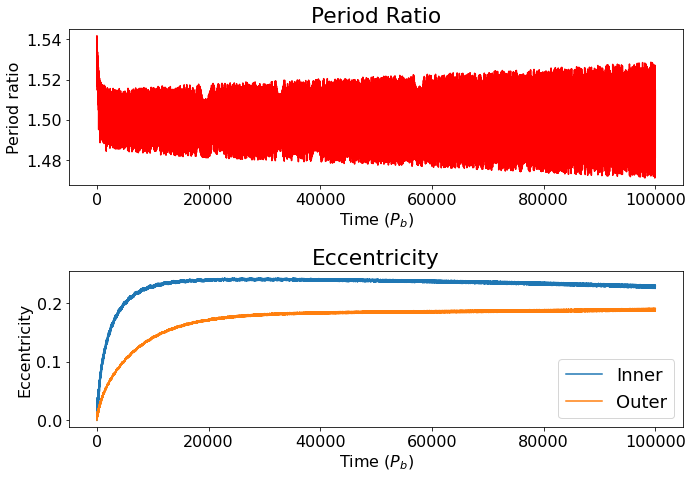

In [44]:
import matplotlib.pyplot as plt

pr = p_outer/p_inner

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
plt.rc('font', size=18)
pr_fig, ecc_fig = axs[0], axs[1]# , axs[0, 1] (no sma fig required)
# period ratio
pr_fig.plot(migration_times, pr, label = 'Period ratio', color='red')
pr_fig.set(xlabel=r'Time ($P_b$)', ylabel='Period ratio', title='Period Ratio')
# pr_fig.set_xlim(right=20000)
# eccentricity
ecc_fig.plot(migration_times, e_inner, label = 'Inner')
ecc_fig.plot(migration_times, e_outer, label = 'Outer')
ecc_fig.set(xlabel = r'Time ($P_b$)', ylabel = 'Eccentricity', title = 'Eccentricity')
# ecc_fig.set_xlim(right=20000)
ecc_fig.legend()
plt.tight_layout()
# plt.savefig('pr_ecc_damping.png', fmt='png')
plt.show()

Take the equilibrium system status, and use that as the starting $\mathbf{z}'$ values for our root-finding:

In [45]:
eq_sim = get_simple_sim(masses, integrator = 'ias15')
eq_sim.integrate(time_base + t_end)
eq_sim_pvars = cm.poincare.Poincare.from_Simulation(eq_sim)
eq_sim_pvars.values

[3.0306925129138014, 4.9436555445488655e-05, -0.0, 2.5306778252719297, -1.1760
451090926102e-06, -0.0, 0.00011782675947764135, 6.561580824716234e-05, 0.0, 0.
00038211018782464084, -6.135499803809231e-05, 0.0]

In [46]:
eq_sim_pvars.to_Simulation()

<rebound.simulation.Simulation object at 0x7f23b275c3c0, N=3, t=100000.0>

Convert from $\left(\eta, \kappa\right) \to \left(p, \theta\right)$ coordinates and get the $\{\theta_1, \theta_2, p_1, p_2, \Psi\}$ values:

In [47]:
ct.old_to_new_array(eq_sim_pvars.values), ct.new_qp_vars

(array([ 2.17633762e+00, -1.59177867e+00,  1.53064845e+00,  5.00014688e-01,
        -0.00000000e+00, -0.00000000e+00,  3.37470365e-09,  1.88290943e-09,
         4.99931690e-04,  1.11770065e-03,  0.00000000e+00,  0.00000000e+00]),
 [theta_1, theta_2, l, psi, phi_1, phi_2, p_1, p_2, L, Psi, Phi_1, Phi_2])

In [48]:
eq_vals = list(filter(None, [ct.old_to_new_array(eq_sim_pvars.values)[i] if ct.new_qp_vars[i] in zs else None for i in range(0, len(ct.new_qp_vars))]))
zs, eq_vals

([θ₁, θ₂, ψ, p₁, p₂, Ψ], [2.176337618430932, -1.5917786726888075, 0.5000146876
418716, 3.3747036531216256e-09, 1.882909433176466e-09, 0.0011177006540822056])

Then convert from $(p, \theta) \to (p', \theta')$ using the same $L$ transformation as earlier:

In [49]:
z_prime_eq_values = np.array([eq_vals[i]/L_val if zs[i] in [p1, p2, Psi] else eq_vals[i] for i in range(0, len(zs))])
z_prime_eq_values

array([ 2.17633762e+00, -1.59177867e+00,  5.00014688e-01,  2.95440542e-07,
        1.64840484e-07,  9.78498028e-02])

Use `scipy.integrate.solve_ivp()`:

Try only conservative `zh_pb()` part, and only dissipative `tauprime_z_dissipative_normalized()` part:

In [50]:
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val = inner.params['tau_a'], outer.params['tau_a'], inner.params['tau_e'], outer.params['tau_e']

In [51]:
# zh_pb_final = zh_pb.subs([(tau_a_1, tau_a_1_val), (tau_a_2, tau_a_2_val), (tau_e_1, tau_e_1_val), (tau_e_2, tau_e_2_val)])
tauprime_z_dissipative_normalized_final = tauprime_z_dissipative_normalized.subs([(tau_a_1, tau_a_1_val), (tau_a_2, tau_a_2_val), (tau_e_1, tau_e_1_val), (tau_e_2, tau_e_2_val)])

zh_pb, tauprime_z_dissipative_normalized_final

⎛⎡    3.6378726352881e-8          1.09158476074847e-9       6.732084745427e-7⋅
⎜⎢────────────────────────── + ────────────────────────── + ──────────────────
⎜⎢                         3                            3               _____ 
⎜⎢(-Ψ′ + 3⋅p′₁ + 3⋅p′₂ + 3)    (-Ψ′ + 2⋅p′₁ + 2⋅p′₂ + 2)              ╲╱ p′₁  
⎜⎢                                                                            
⎜⎢    3.6378726352881e-8          1.09158476074847e-9       4.6072281454748e-7
⎜⎢────────────────────────── + ────────────────────────── - ──────────────────
⎜⎢                         3                            3                _____
⎜⎢(-Ψ′ + 3⋅p′₁ + 3⋅p′₂ + 3)    (-Ψ′ + 2⋅p′₁ + 2⋅p′₂ + 2)               ╲╱ p′₂ 
⎜⎢                                                                            
⎜⎢                     1.2126242117627e-8          5.45792380374233e-10       
⎜⎢               - ────────────────────────── - ──────────────────────────    
⎜⎢                                          3       

In [52]:
t = sp.symbols('t')
zdot_func_ivp = sp.lambdify([t, zprime_p], zdot_final)
cons_func_ivp = sp.lambdify([t, zprime_p], zh_pb)
dis_func_ivp = sp.lambdify([t, zprime_p], tauprime_z_dissipative_normalized_final)

zdot_func_ivp, cons_func_ivp, dis_func_ivp

(<function _lambdifygenerated(t, _Dummy_24)>,
 <function _lambdifygenerated(t, _Dummy_25)>,
 <function _lambdifygenerated(t, _Dummy_26)>)

In [53]:
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

(48868.50808834412, -104855.61284632873, -33333.333333333336, -33333.333333333
336)

In [54]:
from scipy.integrate import solve_ivp
# eq_ivp_sols = solve_ivp(fun=lambda t, z: zdot_func_ivp(t, z).flatten(), t_span=[0, t_end], t_eval = np.linspace(0, t_end, 100000), y0=z_prime_eq_values)

# conservative part
eq_ivp_sols = solve_ivp(fun=lambda t, z: cons_func_ivp(t, z).flatten(), t_span=[0, t_end], t_eval = np.linspace(0, t_end, 100000), y0=z_prime_eq_values)

# dissipative part
# eq_ivp_sols = solve_ivp(fun=lambda t, z: dis_func_ivp(t, z).flatten(), t_span=[0, t_end], t_eval = np.linspace(0, t_end, 100000), y0=z_prime_eq_values)
eq_ivp_sols

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 62
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000e+00, 1.00001e+00, 2.00002e+00, ..., 9.99980e+04,
       9.99990e+04, 1.00000e+05])
 t_events: None
        y: array([[ 2.17633762e+00,  2.17534203e+00,  2.17434931e+00, ...,
         1.57421769e+00,  1.57421766e+00,  1.57421763e+00],
       [-1.59177867e+00, -1.59174505e+00, -1.59171154e+00, ...,
        -1.57084884e+00, -1.57084883e+00, -1.57084883e+00],
       [ 5.00014688e-01,  5.00014687e-01,  5.00014686e-01, ...,
         4.99957942e-01,  4.99957941e-01,  4.99957940e-01],
       [ 2.95440542e-07,  2.96292407e-07,  2.97146084e-07, ...,
         9.15185181e-03,  9.15203397e-03,  9.15221613e-03],
       [ 1.64840484e-07,  1.65369872e-07,  1.65900108e-07, ...,
         4.29888875e-03,  4.29897419e-03,  4.29905963e-03],
       [ 9.78498028e-02,  9.78498028e-02,  9.78498028e-02, ...,
         9.78

In [55]:
e_inner_eq = np.zeros(len(eq_ivp_sols.y.T))
e_outer_eq = np.zeros(len(eq_ivp_sols.y.T))
# e_inner_rb, e_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

p_inner_eq, p_outer_eq = np.zeros(len(eq_ivp_sols.y.T)), np.zeros(len(eq_ivp_sols.y.T))
# p_inner_rb, p_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

eq_sim = get_simple_sim(masses, integrator = 'ias15')
eq_sim_pvars = cm.Poincare.from_Simulation(eq_sim)

indices = np.array([ct.new_qp_vars.index(v) for v in zs])
y0 = ct.old_to_new_array(eq_sim_pvars.values)
    
for i, val in enumerate(eq_ivp_sols.y.T):
    # transfrom back from p' to p
    transformed_val = np.array([val[i] * L_val if zs[i] in [p1, p2, Psi] else val[i] for i in range(0, len(zs))])
    y0[indices] = transformed_val
    # and then to eta, kappa
    eq_sim_pvars.values = ct.new_to_old_array(y0)
    
    e_inner_eq[i] = eq_sim_pvars.particles[1].e
    e_outer_eq[i] = eq_sim_pvars.particles[2].e
    
    p_inner_eq[i] = eq_sim_pvars.particles[1].P
    p_outer_eq[i] = eq_sim_pvars.particles[2].P

AttributeError: sGamma:0.15699690030824967, sLambda:0.07849797230769508, GbyL:2.000012174745811, val:-2.4349639846654725e-05

Plot:

In [ ]:
e_inner_eq[0], e_outer_eq[0], get_simple_sim(masses).particles[1].e, get_simple_sim(masses).particles[2].e

In [ ]:
plt.figure(figsize = (14, 10))
# plt.plot(eq_ivp_sols.t, e_inner_eq, label = '')
# plt.plot(eq_ivp_sols.t, e_outer_eq, label = '')
plt.plot(eq_ivp_sols.t, e_inner_eq, label = 'inner eom') 
plt.plot(eq_ivp_sols.t, e_outer_eq, label = 'outer eom')
plt.legend()


Solve with Newton's, using the multivariate Newton's method rather than scipy's built-in `scipy.optimize.root()`:

In [ ]:
from scipy.linalg import solve as lin_solve 
# newton's method
def newton_solve(fun,Dfun,guess,max_iter=100,rtol=1e-6,atol=1e-12):
    y = guess.copy()
    for itr in range(max_iter):
        f = fun(y)
        Df = Dfun(y)
        print(f, Df)
        dy = -1 * lin_solve(Df,f)
        y+=dy
        print(y)
        if np.alltrue( np.abs(dy) < rtol * np.abs(y) + atol ):
            break
    else:
        print("did not converge")
    return y

In [ ]:
jac_vars = [theta1, theta2, p1prime, p2prime, Psiprime]

In [ ]:
jac_vars, zprime_p

In [ ]:
zdot_final

In [ ]:
zdot_deleted = zdot_final.row_del(2)
zdot_deleted

Compute the Jacobian and then solve:

In [ ]:
zjac = zdot_deleted.jacobian(jac_vars)
zjac

Lambdify and solve:

In [ ]:
zjac_func = sp.lambdify([jac_vars], zjac)  # lambdify
zjac_func

In [ ]:
zdot_deleted_func = sp.lambdify([jac_vars], zdot_deleted)
zdot_deleted_func

In [ ]:
np.linalg.solve(zjac_func(newton_guess), zdot_deleted_func(newton_guess).reshape(-1))

In [ ]:
newton_guess = np.delete(z_prime_eq_values, 2)

newton_solve(lambda z: zdot_deleted_func(z).reshape(-1), zjac_func, guess=newton_guess)

Compared to scipy's algorithm:

In [ ]:
from scipy.optimize import fsolve, root
# solve for root
zeq_rb = root(lambda z: zdot_func(z).flatten(), x0=z_prime_eq_values)
z_prime_eq_values, zeq_rb.x, zeq_rb.message


Test to see if $f\left(\mathbf{z}_{eq}\right) = 0$:

In [ ]:
zdot_func(zeq_rb.x), zdot_func(z_prime_eq_values)

Now use Newton's method to solve for a root:

In [ ]:
z_prime_values, zdot_func(z_prime_values).flatten()

In [ ]:
from scipy.optimize import fsolve, root
# solve for root
zeq = root(lambda z: zdot_func(z).flatten(), x0=z_prime_values)
# zeq2 = fsolve(lambda z: zdot_func(z).flatten(), x0=z_prime_values)

z_prime_values, zeq.x, zeq.message

Confirm that $f\left(\mathbf{z^*}\right) = 0$:

In [ ]:
zdot_func(zeq.x), zdot_func(z_prime_values)

norm:

In [ ]:
np.linalg.norm(zdot_func(zeq.x)), np.linalg.norm(zdot_func(z_prime_values))

In [ ]:
new_flow = cons_flow + new_dissipative
new_flow

N = len(z)
new_flow_jac = sp.Matrix(N, N, lambda i,j: sp.diff(new_flow[i], z[j])) 

In [ ]:
t = sp.symbols('t')
new_flow_eom = sp.lambdify([t, z, tau_a_1, tau_a_2, tau_e_1, tau_e_2], new_flow)
new_flow_jac_func = sp.lambdify([t, z, tau_a_1, tau_a_2, tau_e_1, tau_e_2], new_flow_jac)

In [ ]:
times = np.linspace(0, 10000 * inner.P, 1000)

def get_tau_alphas(tau_alpha, m_inner, m_outer, period_ratio):
    # use Kepler's third law to compute the ratio of semi-major axes in resonance from the period ratio in resonance
    sma_ratio = period_ratio ** (2/3)  # ratio of outer planet's semi-major axis to inner
    # define matrix A
    A = np.array([[-1, 1],
                 [m_outer, m_inner * sma_ratio]])
    # compute gamma_1 and gamma_2
    gammas = np.matmul(np.linalg.inv(A), np.array([-1/tau_alpha, 0]))
    # gamma = 1/tau
    taus = 1/gammas
    
    return tuple(taus)  # returns (tau_alpha_outer, tau_alpha_inner) as a tuple

tau_e_factor = 1
K_test = 10
resonant_period_ratio = 3/2

# use tau_e values of timescale/3

tau_e_1_val, tau_e_2_val = -times[-1]/tau_e_factor, -times[-1]/tau_e_factor
tau_e_val = 1 / (1 / tau_e_1_val + 1 / tau_e_2_val)

tau_a_val = tau_e_val * K_test  # use k value

# compute tau_a values
tau_a_2_val, tau_a_1_val = get_tau_alphas(tau_alpha = tau_a_val, m_inner=inner.m, m_outer = outer.m, period_ratio = resonant_period_ratio)
tau_a_1_val, tau_a_2_val, tau_e_1_val, tau_e_2_val

In [ ]:
times[-1]

In [ ]:
[hamxy.qp]

In [ ]:
from scipy.integrate import solve_ivp

y0 = [hamxy.qp[v] for v in z]
# y0[0] += 0.5

# set to negative since reboundx has them as -tau timescales while our eom has them as positive
params = (-tau_a_1_val, -tau_a_2_val, -tau_e_1_val, -tau_e_2_val)  # these are the tau_a and tau_e_params as a tuple

# solving the ivp
sols_xy = solve_ivp(lambda t,x: new_flow_eom(t,x,*params).reshape(-1), [times[0], times[-1]], y0 = y0, t_eval = times, jac = lambda t,x: new_flow_jac_func(t, x, *params), dense_output=True, method='Radau', atol=1e-13)

In [ ]:
e_inner_eom = np.zeros(len(sols_xy.y.T))
e_outer_eom = np.zeros(len(sols_xy.y.T))
e_inner_rb, e_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

p_inner_eom, p_outer_eom = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))
p_inner_rb, p_outer_rb = np.zeros(len(sols_xy.y.T)), np.zeros(len(sols_xy.y.T))

indices = np.array([hamxy.qp_vars.index(v) for v in z])
y0 = np.array(hamxy.values)
    
for i, val in enumerate(sols_xy.y.T):
    y0[indices] = val
    pvars.values = ctcomp.new_to_old_array(y0)
    
    e_inner_eom[i] = pvars.particles[1].e
    e_outer_eom[i] = pvars.particles[2].e
    
    p_inner_eom[i] = pvars.particles[1].P
    p_outer_eom[i] = pvars.particles[2].P
    
    
# add reboundx to the simulation
sim = get_sim_from_params(fit_params, inclination = np.pi/2, integrator = 'ias15', time_base = 0)
rebx = reboundx.Extras(sim)
rebx.add_force(rebx.load_force('modify_orbits_forces'))
rebx.add_operator(rebx.load_operator('modify_orbits_direct'))

inner = sim.particles[1]
outer = sim.particles[2]

inner.params['tau_e'] = tau_e_1_val  # eccentricity damping, these stay constant
outer.params['tau_e'] = tau_e_2_val

inner.params['tau_a'], outer.params['tau_a'] = tau_a_1_val, tau_a_2_val

from tqdm import tqdm    

for i, t in tqdm(enumerate(sols_xy.t)):
    sim.integrate(t)
    e_inner_rb[i] = inner.e
    e_outer_rb[i] = outer.e
    p_inner_rb[i] = inner.P
    p_outer_rb[i] = outer.P

In [ ]:
plt.figure(figsize = (14, 10))
plt.plot(sols_xy.t, p_outer_rb/p_inner_rb, label = 'rebound')
plt.plot(sols_xy.t, p_outer_eom/p_inner_eom, label = 'eom')
plt.legend()

In [ ]:
plt.figure(figsize = (14, 10))
plt.plot(sols_xy.t, e_inner_rb, label = 'inner rebound')
plt.plot(sols_xy.t, e_outer_rb, label = 'outer rebound')
plt.plot(sols_xy.t, e_inner_eom, label = 'inner eom') 
plt.plot(sols_xy.t, e_outer_eom, label = 'outer eom')
plt.legend()
